In this notebook we look at how to use the gradient of the horsetail matching metric to speed up optimizations.

In [9]:
import numpy
import matplotlib.pyplot as plt

from horsetailmatching import UncertainParameter, HorsetailMatching
from horsetailmatching.demoproblems import TP1, TP2

First we will look at the purely probabilistic case and a simple test problem. We set up the uncertain parameters and create the horsetail matching object as usual. Note that in order to propagate gradients, we must use the kernel based method of evaluating the horsetail matching metric. 

In [10]:
u1 = UncertainParameter('uniform', lower_bound=-1, upper_bound=1)
u2 = UncertainParameter('uniform', lower_bound=-1, upper_bound=1)
input_uncertainties = [u1, u2]

Horsetail matching uses the same syntax for specifying a gradient as the scipy.minimize function, through the 'jac' argument. If 'jac' is True, then horsetail matching expects the qoi function to also return the jacobian of the qoi (the gradient with respect to the design variables). Alternatively 'jac' is a fuction that similarly to the qoi function takes two inputs (the values of the design variables and uncertainties), and returns the gradient. The following code demonstrates these alternatives:

In [17]:
fun_qjac = lambda x, u: TP1(x, u, jac=True)  # Returns both qoi and its gradient
fun_q = lambda x, u: TP1(x, u, jac=False)  # Returns just the qoi
fun_jac = lambda x, u: TP1(x, u, jac=True)[1]  # Returns just the gradient

theHM = HorsetailMatching(fun_qjac, input_uncertainties, jac=True, method='kernel', kernel_bandwidth=0.001,
                          samples_prob=2000, integration_points=numpy.linspace(-1, 5, 500))

theHM = HorsetailMatching(fun_q, input_uncertainties, jac=fun_jac, method='kernel', kernel_bandwidth=0.001,
                          samples_prob=2000, integration_points=numpy.linspace(-1, 5, 500))

print(theHM.evalMetric([1,1]))

(0.5804964838897805, array([ 0.40472863,  0.40472863]))


Now we can use this in a gradient based optimizer:

In [18]:
from scipy.optimize import minimize

solution = minimize(theHM.evalMetric, x0=[1,1], method='BFGS', jac=True)
print(solution)

   status: 0
  success: True
     njev: 9
     nfev: 9
 hess_inv: array([[ 16.21648913,  15.21648913],
       [ 15.21648913,  16.21648913]])
      fun: 0.010253277219761107
        x: array([-0.0723969, -0.0723969])
  message: 'Optimization terminated successfully.'
      jac: array([  8.76890404e-06,   8.76890404e-06])


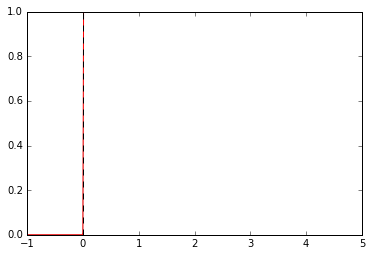

In [19]:
(x1, y1), (x2, y2), CDFs = theHM.getHorsetail()

for (x, y) in CDFs:
    plt.plot(x, y, c='grey', lw=0.5)
plt.plot(x1, y1, 'r')
plt.plot([theHM.ftarget(y) for y in y1], y1, 'k--')
plt.xlim([-1, 5])
plt.show()

Once again the optimizer has found the optimum at x=[0,0], but this time in much fewer iterations. This concludes our illustration of using horsetail matching with gradients. For other tutorials, please visit http://www-edc.eng.cam.ac.uk/aerotools/horsetailmatching/